# Generating synthetic datasets

## Imports

In [71]:
import numpy as np                     # Packages for Data Analysis
import pandas as pd
import random as rand
from scipy.signal import correlate, correlation_lags

import matplotlib.pyplot as plt       # Packages for making plots
from matplotlib.patches import FancyArrow
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d

import braingeneers                  # Braigneneers packages for analysis
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster
import braingeneers.data.datasets_electrophysiology as ephys
import random

## Propagation data generation

In [86]:
# def generate_spike_data_with_pattern(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms):
#     N_channels = rows * cols
#     adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
#     segment_duration_ms = adjusted_total_duration_ms / num_propagations
    
#     # Initialize positions and neuron_data
#     positions = [(x, y) for x in range(rows) for y in range(cols)]
#     neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}
    
#     # Initialize train with empty lists for each channel
#     train_patterned_overlap = [[] for _ in range(N_channels)]
    
#     # Generate spike times with specified overlap, breaks, and random firing within rows
#     for propagation in range(num_propagations):
#         segment_start = propagation * (segment_duration_ms + break_duration_ms)
        
#         for row in range(rows):
#             row_start = segment_start + (row * (segment_duration_ms / rows - overlap_duration_ms))
#             spike_time_start = row_start
#             spike_time_end = spike_time_start + (segment_duration_ms / rows) + overlap_duration_ms
            
#             # Randomly decide which neurons in the row will fire (random proportion)
#             firing_neurons_in_row = random.sample(range(row * cols, (row + 1) * cols), random.randint(1, cols))
            
#             for neuron_index in firing_neurons_in_row:
#                 spike_times = np.linspace(spike_time_start, spike_time_end, int(segment_duration_ms / rows / 10))
#                 train_patterned_overlap[neuron_index].extend(spike_times)
    
#     # Convert lists to numpy arrays
#     train_patterned_overlap = [np.array(times) for times in train_patterned_overlap]
    
#     # Create the SpikeData object
#     spike_data_patterned_random_firing = SpikeData(train=train_patterned_overlap, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)
    
#     return spike_data_patterned_random_firing


def generate_spike_data_with_pattern(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms):
    N_channels = rows * cols
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
    segment_duration_ms = adjusted_total_duration_ms / num_propagations

    # Initialize positions and neuron_data
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

    # Initialize train with empty lists for each channel
    train_patterned_overlap = [[] for _ in range(N_channels)]
    
    # Pre-assign at least one firing event for each neuron across the propagations
    preassigned_firings = {neuron_index: random.randint(0, num_propagations - 1) for neuron_index in range(N_channels)}

    # Generate spike times with specified overlap, breaks, and random firing within rows
    for propagation in range(num_propagations):
        segment_start = propagation * (segment_duration_ms + break_duration_ms)

        for row in range(rows):
            row_start = segment_start + (row * (segment_duration_ms / rows - overlap_duration_ms))
            spike_time_start = row_start
            spike_time_end = spike_time_start + (segment_duration_ms / rows) + overlap_duration_ms

            # Randomly decide which neurons in the row will fire (random proportion)
            firing_neurons_in_row = random.sample(range(row * cols, (row + 1) * cols), random.randint(1, cols))

            # Ensure pre-assigned neurons for this propagation are included
            for neuron_index in range(row * cols, (row + 1) * cols):
                if preassigned_firings[neuron_index] == propagation and neuron_index not in firing_neurons_in_row:
                    firing_neurons_in_row.append(neuron_index)

            for neuron_index in firing_neurons_in_row:
                spike_times = np.linspace(spike_time_start, spike_time_end, int(segment_duration_ms / rows / 10))
                train_patterned_overlap[neuron_index].extend(spike_times)

    # Convert lists to numpy arrays
    train_patterned_overlap = [np.array(times) for times in train_patterned_overlap]

    # Create the SpikeData object
    spike_data_patterned_random_firing = SpikeData(train=train_patterned_overlap, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

    return spike_data_patterned_random_firing

def generate_overlap_spike_data(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms):
    N_channels = rows * cols
    # Calculate adjusted segment and row durations
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
    segment_duration_ms = adjusted_total_duration_ms / num_propagations
    
    # Initialize positions and neuron_data
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}
    
    # Initialize train with empty lists for each channel
    train_patterned_overlap = [[] for _ in range(N_channels)]
    
    # Generate spike times with specified overlap and breaks
    for propagation in range(num_propagations):
        segment_start = propagation * (segment_duration_ms + break_duration_ms)
        
        for row in range(rows):
            row_start = segment_start + (row * (segment_duration_ms / rows - overlap_duration_ms))
            spike_time_start = row_start
            spike_time_end = spike_time_start + (segment_duration_ms / rows) + overlap_duration_ms
            
            for col in range(cols):
                channel_index = row * cols + col
                spike_times = np.linspace(spike_time_start, spike_time_end, int(segment_duration_ms / rows / 10))
                train_patterned_overlap[channel_index].extend(spike_times)
    
    # Convert lists to numpy arrays
    train_patterned_overlap = [np.array(times) for times in train_patterned_overlap]
    
    # Create the SpikeData object for the new dataset
    spike_data_patterned_overlap = SpikeData(train=train_patterned_overlap, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)
    
    return spike_data_patterned_overlap



## Helper functions

In [3]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)


## Plotting functions

In [55]:
def firing_plotter(sd):

    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []

    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    # Adjust size scaling for more variance
    min_rate, max_rate = np.min(firing_rates), np.max(firing_rates)
    sizes = ((firing_rates - min_rate) / (max_rate - min_rate) * 300) + 10  # Normalize and scale

    plt.figure(figsize=(8, 6))
    # scatter = plt.scatter(neuron_x, neuron_y, s=sizes/1.5, c=firing_rates, alpha=0.6, cmap=cm)
    scatter = plt.scatter(neuron_x, neuron_y, s=sizes/1.5, c=firing_rates, alpha=0.6, cmap=cm)
    plt.title("Neuron Firing Rates")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.show()

def plot_raster(sd):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()


## Data visualizations

In [91]:
overlap_spike_data = generate_overlap_spike_data(
    total_duration_ms=60 * 1000,  # 60 seconds in milliseconds
    num_propagations=5,
    rows=16,
    cols=16,
    overlap_duration_ms=100,
    break_duration_ms=5000  # 5 seconds
)

random_overlap_spike_data = generate_spike_data_with_pattern(
    total_duration_ms=60 * 1000,  # 1 minute
    num_propagations=5,
    rows=16,
    cols=16,
    overlap_duration_ms=100,
    break_duration_ms=5000  # 5 seconds
)

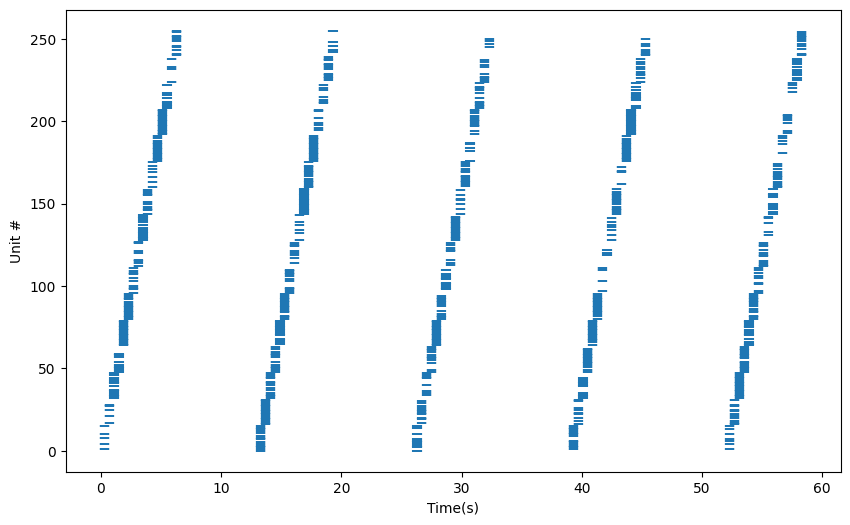

In [92]:
plot_raster(random_overlap_spike_data)

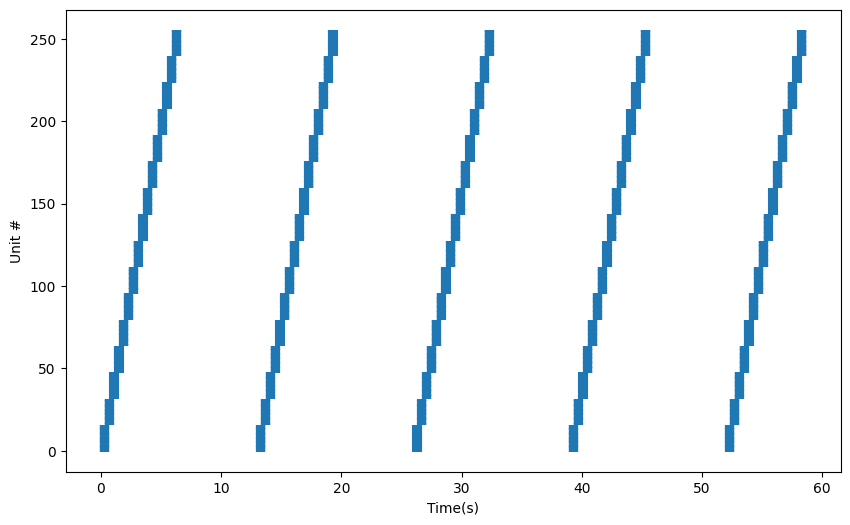

In [39]:
plot_raster(overlap_spike_data)

/tmp/ipykernel_10225/706780804.py:13: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for i, neuron in sd.neuron_data['positions'].items():


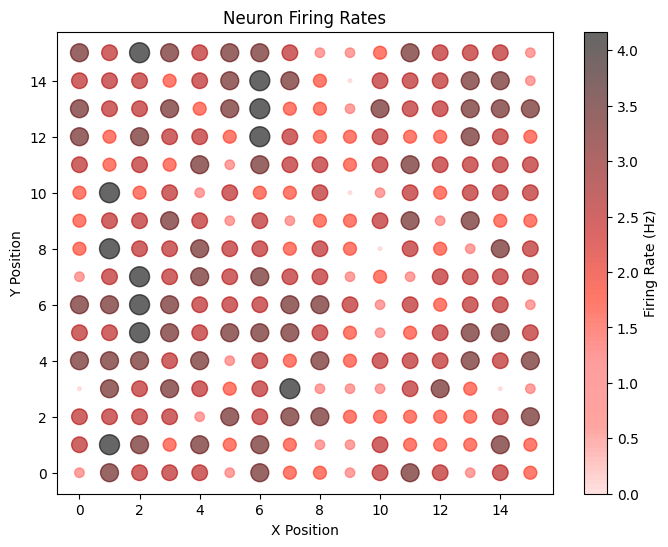

In [56]:
firing_plotter(random_overlap_spike_data)

## Methods

### Functional Connectivity

In [97]:
def latencies_mean_neuron(lat_list):
    """
    Output: Returns a list containing the mean latencies for each sublist.
    Input: lat_list- A list of lists representing latencies between a particular neuron, x, and all others. Created with `sd.latencies_to_index(x)`
    """
    nested_list = lat_list
    for i in range(len(nested_list)):
        sublist = nested_list[i]
        length = len(sublist)
        if length == 0:
            sublist_mean = 0
        else:
            sublist_mean = sum(sublist)/len(sublist)
            sublist_mean = round(sublist_mean, 3) # Round to 3d.p.
        nested_list[i] = sublist_mean
    return nested_list

def latencies_mean_all(sd):
    """
    Output: Returns a list of lists containing the mean latencies between all neurons
    Input: sd- A SpikeData object, the standard data format for braingeneers
    """
    latencies_array = [None] * sd.N
    for curr_neuron in range(sd.N):
        latencies = latencies_mean_neuron(sd.latencies_to_index(curr_neuron))
        latencies_array[curr_neuron] = latencies # Store mean latency in corresponding position of 'latencies_array2'
    return latencies_array

def get_in_out_degree( mean_latency_matrix ): 
    """
    Output: Returns a list of tuples, [(incoming,outgoing),....] , containing the in and out degree for each neuron. 
            This is the number of "receicer" and "sender" signals the neurons get from other neurons
    Input: mean_latency_matrix- A list of lists containing the mean latency between all neurons
    """
    in_out_deg = [(0, 0) for _ in range(len(mean_latency_matrix))]
    for curr_neuron in range(len(mean_latency_matrix)):
        in_deg = 0
        out_deg = 0
        curr_neural_latencies = mean_latency_matrix[curr_neuron]
        for i in range(len(curr_neural_latencies)):
            if curr_neural_latencies[i] > 0:
                out_deg += 1
            if curr_neural_latencies[i] < 0:
                in_deg += 1
        in_out_deg[curr_neuron] = (in_deg, out_deg)
    return in_out_deg

def label_sender_receiver_neurons(in_out_deg, latency_thresh=0.2):
    node_info = ['grey'] * len(in_out_deg)
    for i in range(len(in_out_deg)):
        if (in_out_deg[i][1] + in_out_deg[i][0]) == 0:
            test1 = 0
            test2 = 0
        else:
            test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
            test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])
        
        if test1 > latency_thresh:
            node_info[i] = 'red'
        elif test2 > latency_thresh:
            node_info[i] = 'blue'
    return node_info

def plot_functional_connectivity_map( sd, latency_threshold=.1, show_sttc=True,  sttc_threshold=.1):
    """
    Output: plots the functional connectivity map, displayin "sender" and ""receiver" neurons in the neural circuit
    Inputs:
        sd (SpikeData object)- the standard data format for braingeneers
        latency_threshold (float)- Between 0-1. The threshold for the fraction of in/out signals a neuron must have to be labelled a "sender" or "receiver"
        show_sttc (boolean)- If True, the spike time tiling connections between neurons are also plotted
        sttc_threshold (float)- Between 0-1. The strength a spike time tiling correlation must be above in order to be plotted
    """
    # Plot functional connectivity map
    print("calculating all latencies...")
    all_mean_latencies = latencies_mean_all(sd)
    in_out_deg = get_in_out_degree(all_mean_latencies)
    sender_receiver_neurons = label_sender_receiver_neurons(in_out_deg, latency_threshold )
    print("making plot")
    neuron_x = []
    neuron_y = []
    for neuron in sd.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    plt.figure(figsize=(8,6))
    plt.scatter(neuron_x, neuron_y, c=sender_receiver_neurons)
    # Plot legend for functional connectivity map
    node_type_legend_elements = [
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]
    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')
    plt.gca().add_artist(node_type_legend)
    plt.title("Neuron layout")
    plt.xlabel('um')
    plt.ylabel('um')

    # Plot spike time tiling connections between neurons
    if show_sttc:
        sttc = sd.spike_time_tilings(delt=40)
        for i in range(sttc.shape[0]):
            for j in range(sttc.shape[1]):
                if i <= j: continue
                if sttc[i,j] < sttc_threshold : continue
                ix,iy = sd.neuron_data['positions'][i]['position']
                jx,jy = sd.neuron_data['positions'][j]['position']
                # ix,iy = sd.neuron_data[0][i]['position']
                # jx,jy = sd.neuron_data[0][j]['position']
                linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)  # Modify opacity based on correlation
                # Plot line between the points with linewidth and opacity
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
        # Create legend for spike time tilings
        correlation_legend_elements = [
            plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
            plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
            plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
        ]
        correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
        plt.gca().add_artist(correlation_legend)

    plt.show()

calculating all latencies...
making plot


/tmp/ipykernel_10225/2055896706.py:81: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data['positions'].values():
/tmp/ipykernel_10225/2055896706.py:105: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  ix,iy = sd.neuron_data['positions'][i]['position']
/tmp/ipykernel_10225/2055896706.py:106: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  jx,jy = sd.neuron_data['positions'][j]['position']


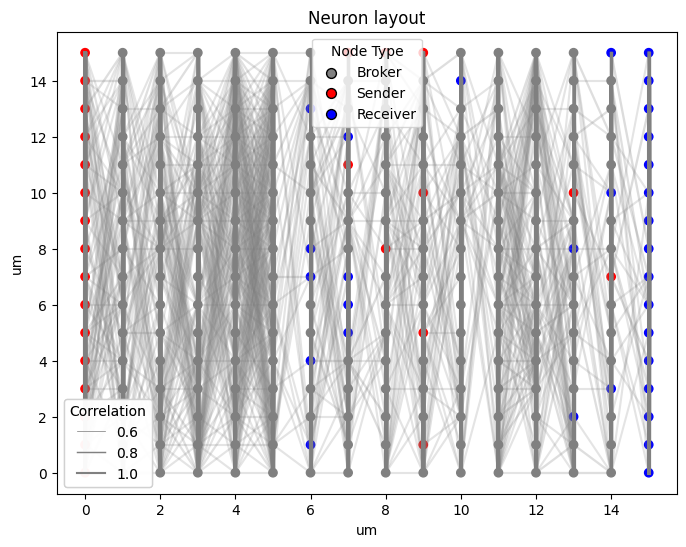

In [98]:
plot_functional_connectivity_map(random_overlap_spike_data, latency_threshold=.1, show_sttc=True,  sttc_threshold=.3)

calculating all latencies...
making plot


/tmp/ipykernel_10225/3490166313.py:81: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data['positions'].values():
/tmp/ipykernel_10225/3490166313.py:105: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  ix,iy = sd.neuron_data['positions'][i]['position']
/tmp/ipykernel_10225/3490166313.py:106: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  jx,jy = sd.neuron_data['positions'][j]['position']


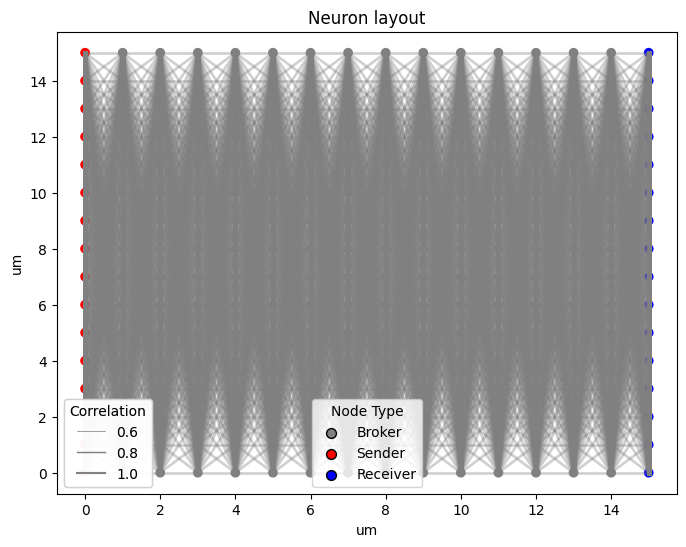

In [75]:
plot_functional_connectivity_map(overlap_spike_data, latency_threshold=.1, show_sttc=True,  sttc_threshold=.1)

In [ ]:
overlap_spike_data.neuron_data[0][i]

In [65]:
for neuron in random_overlap_spike_data.neuron_data['positions'].values():
    print(neuron['position'][1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


/tmp/ipykernel_10225/2066731310.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in random_overlap_spike_data.neuron_data['positions'].values():


### Spatial Activity Profiles

### Latency-vector method